In [ ]:
#%%

import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score 
from sklearn.metrics import roc_auc_score, roc_curve, classification_report,precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import defaultdict

In [ ]:
#%%

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
#%%

warnings.filterwarnings('ignore')

base = pd.read_csv('D:/Users/tonyn/Desktop/da_sci_4th/datathon/DATA/Base.csv')
base_copy = base.copy()

var1 = pd.read_csv('D:/Users/tonyn/Desktop/da_sci_4th/datathon/DATA/Variant I.csv')
var1_copy = var1.copy()

var2 = pd.read_csv('D:/Users/tonyn/Desktop/da_sci_4th/datathon/DATA/Variant II.csv')
var2_copy = var2.copy()

var3 = pd.read_csv('D:/Users/tonyn/Desktop/da_sci_4th/datathon/DATA/Variant III.csv')
var3_copy = var3.copy()

var4 = pd.read_csv('D:/Users/tonyn/Desktop/da_sci_4th/datathon/DATA/Variant IV.csv')
var4_copy = var4.copy()

var5 = pd.read_csv('D:/Users/tonyn/Desktop/da_sci_4th/datathon/DATA/Variant V.csv')
var5_copy = var5.copy()

In [ ]:
#%%

### EDA dataset preprocessing ###
def EDA_dataset(df):
    drop_col = ['payment_type', 'employment_status', 'prev_address_months_count', 'intended_balcon_amount', 'housing_status', 'days_since_request']
    df.drop(columns = drop_col, inplace = True)

    df = df[df['current_address_months_count'] >= 0]

    df['bank_months_count'].replace({-1: 0}, inplace = True)

    df = df[df['session_length_in_minutes'] >= 0]

    df['proposed_credit_limit'] = df['proposed_credit_limit'].astype(int)


    return df

In [ ]:
# %%

base_copy = EDA_dataset(base_copy)
var1_copy = EDA_dataset(var1_copy)
var2_copy = EDA_dataset(var2_copy)
var3_copy = EDA_dataset(var3_copy)
var4_copy = EDA_dataset(var4_copy)
var5_copy = EDA_dataset(var5_copy)

In [ ]:
# %%

### One-hot encoding for categorical variables####
def one_hot(df):
    object_cols = ['source', 'device_os']
    df = pd.get_dummies(df, columns=object_cols, drop_first=True, dtype=int)

    return df

In [ ]:
# %%

base_copy = one_hot(base_copy)
var1_copy = one_hot(var1_copy)  
var2_copy = one_hot(var2_copy)
var3_copy = one_hot(var3_copy)
var4_copy = one_hot(var4_copy)
var5_copy = one_hot(var5_copy)

In [ ]:
#%%

###100만개 데이터 중 10만개씩 sampling###
def sample_data_stratified(df):
    df.loc[(df['customer_age'] < 50) & (df['fraud_bool'] == 0), 'group'] = 0
    df.loc[(df['customer_age'] < 50) & (df['fraud_bool'] == 1), 'group'] = 1
    df.loc[(df['customer_age'] >= 50) & (df['fraud_bool'] == 0), 'group'] = 2
    df.loc[(df['customer_age'] >= 50) & (df['fraud_bool'] == 1), 'group'] = 3
    df['group'] = df['group'].astype(int)

    X = df.drop(columns=['group'])
    y = df['group']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    
    return X_train, X_test, y_train, y_test

In [ ]:
#%%

base_sam, X_test, y_train, y_test = sample_data_stratified(base_copy)
var1_sam, X_test, y_train, y_test = sample_data_stratified(var1_copy)
var2_sam, X_test, y_train, y_test = sample_data_stratified(var2_copy)
var3_sam, X_test, y_train, y_test = sample_data_stratified(var3_copy)
var4_sam, X_test, y_train, y_test = sample_data_stratified(var4_copy)
var5_sam, X_test, y_train, y_test = sample_data_stratified(var5_copy)

In [ ]:
# %%

##### Correlation Matrix Heatmap ###

# df = [base_copy, var1_copy, var2_copy, var3_copy, var4_copy, var5_copy]
# for df in df:
#     correlation_matrix = df.corr(numeric_only=True)
#     plt.figure(figsize=(35, 35))
#     sns.heatmap(
#         correlation_matrix,  
#         annot=True,          
#         cmap='coolwarm',     
#         fmt=".2f",          
#         linewidths=.5,      
#         cbar=True           
#     )
#     plt.title('Correlation Matrix Heatmap')
#     plt.show()

In [ ]:
# %%

# #### Distribution of All Columns ###
# num_cols = len(base_copy.columns)
# x = 4
# y = (num_cols + x - 1) // x 
# plt.figure(figsize=(x * 5, y * 4))
# for i, col in enumerate(base_copy.columns):
#     plt.subplot(y, x, i + 1)

#     if base_copy[col].nunique() < 5 and base_copy[col].dtype == 'int64':
#             sns.countplot(x=col, data=base_copy)
#             plt.xlabel(col, fontsize=10)
#             plt.ylabel('Count', fontsize=10)

#     else:
#         sns.histplot(base_copy[col], kde=True, bins=30)
#         plt.xlabel(col, fontsize=10)
#         plt.ylabel('Frequency', fontsize=10)

# plt.tight_layout()
# plt.suptitle('All Columns Distribution', y=1.02, fontsize=18) 
# plt.show()

In [ ]:
#%%

# # --- fraud_bool이 1인 경우의 모든 컬럼 분포 시각화 ---
# fraud_data = base_copy[base_copy['fraud_bool'] == 1]

# # 사기 데이터셋에 대한 컬럼 수 계산 (동일할 수 있지만, 명시적으로 다시 계산)
# num_fraud_cols = len(fraud_data.columns)
# x_fraud = 4 # 동일한 레이아웃 유지
# y_fraud_rows = (num_fraud_cols + x_fraud - 1) // x_fraud 

# plt.figure(figsize=(x_fraud * 5, y_fraud_rows * 4))
# for i, col in enumerate(fraud_data.columns):
#     plt.subplot(y_fraud_rows, x_fraud, i + 1)

#     # 이산형 변수 (카운트 플롯)와 연속형 변수 (히스토그램) 구분
#     if fraud_data[col].nunique() < 5 and fraud_data[col].dtype == 'int64':
#         sns.countplot(x=col, data=fraud_data)
#         plt.xlabel(col, fontsize=10)
#         plt.ylabel('Count', fontsize=10)
#     else:
#         sns.histplot(fraud_data[col], kde=True, bins=30)
#         plt.xlabel(col, fontsize=10)
#         plt.ylabel('Frequency', fontsize=10)

# plt.tight_layout()
# plt.suptitle('All Columns Distribution (for fraud_bool = 1)', y=1.02, fontsize=18) 
# plt.show()

In [ ]:
# %%

### Modeling ###
## data splitting for modeling
def split_train_test(df):
    df.loc[(df['customer_age'] < 50) & (df['fraud_bool'] == 0), 'group'] = 0
    df.loc[(df['customer_age'] < 50) & (df['fraud_bool'] == 1), 'group'] = 1
    df.loc[(df['customer_age'] >= 50) & (df['fraud_bool'] == 0), 'group'] = 2
    df.loc[(df['customer_age'] >= 50) & (df['fraud_bool'] == 1), 'group'] = 3
    df['group'] = df['group'].astype(int)
    X = df.drop(columns=['fraud_bool', 'group'])
    y = df['fraud_bool']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['group'])
    
    return X_train, X_test, y_train, y_test

In [ ]:
#%%

x_train_base, x_test_base, y_train_base, y_test_base = split_train_test(base_sam)
x_train_var1, x_test_var1, y_train_var1, y_test_var1 = split_train_test(var1_sam)
x_train_var2, x_test_var2, y_train_var2, y_test_var2 = split_train_test(var2_sam)
x_train_var3, x_test_var3, y_train_var3, y_test_var3 = split_train_test(var3_sam)
x_train_var4, x_test_var4, y_train_var4, y_test_var4 = split_train_test(var4_sam)
x_train_var5, x_test_var5, y_train_var5, y_test_var5 = split_train_test(var5_sam)

In [ ]:
# %%

LGB = LGBMClassifier()

In [ ]:
# %%

def k_fold_training_smote(model_instance, X_train, y_train):
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    
    for fold, (train_index, val_index) in enumerate(k_fold.split(X_train, y_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        pipeline = Pipeline([
            ('smote', SMOTE(random_state=42)), # SMOTE 인스턴스
            ('classifier', model_instance)      # 모델 인스턴스 (하이퍼파라미터가 적용된)
        ])
        # 모델 학습
        pipeline.fit(X_train_fold, y_train_fold)
        y_val_proba = pipeline.predict_proba(X_val_fold)[:, 1]
        auc_score = roc_auc_score(y_val_fold, y_val_proba)
        auc_scores.append(auc_score)

        # 마지막 폴드의 결과 저장
        if fold == k_fold.get_n_splits() - 1:
            last_fold_y_val = y_val_fold
            last_fold_y_proba = y_val_proba
            last_trained_pipeline = pipeline # 마지막 학습된 파이프라인 저장

    return auc_scores, last_fold_y_val, last_fold_y_proba, last_trained_pipeline

In [ ]:
#%%

default_lgb_model = LGBMClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='auc' # K-Fold 평가를 위해 'auc' 사용
)
datasets = {
    'base':  (x_train_base,  x_test_base,  y_train_base,  y_test_base),
    'var1':  (x_train_var1,  x_test_var1,  y_train_var1,  y_test_var1),
    'var2':  (x_train_var2,  x_test_var2,  y_train_var2,  y_test_var2),
    'var3':  (x_train_var3,  x_test_var3,  y_train_var3,  y_test_var3),
    'var4':  (x_train_var4,  x_test_var4,  y_train_var4,  y_test_var4),
    'var5':  (x_train_var5,  x_test_var5,  y_train_var5,  y_test_var5)
}

In [ ]:
#%% 

roc_data = defaultdict(dict)
pr_data = defaultdict(dict)

for name, (X_tr, X_te, y_tr, y_te) in datasets.items():
    print(f"\n==== Processing dataset: {name} ====")

    lgb_model = LGBMClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='auc',  # K-Fold 평가를 위해 'auc' 사용
        scale_pos_weight=10000  # 클래스 불균형을 고려하여 scale_pos_weight 설정
    )

    auc_scores_cv, last_fold_y_val, last_fold_y_proba, last_trained_pipeline = k_fold_training_smote(lgb_model, X_tr, y_tr)
    print(f"  K-Fold Cross-Validation AUC scores: {auc_scores_cv}")
    print(f"  Average CV AUC: {np.mean(auc_scores_cv):.4f}")
    print(f"  CV AUC Standard Deviation: {np.std(auc_scores_cv):.4f}")

    # 중요도 추출
    # 파이프라인 내의 학습된 LGBMClassifier 모델 객체에 접근
    lgbm_classifier_model = last_trained_pipeline.named_steps['classifier']

    # 1. `feature_importances_` 속성 사용 (가장 권장)
    # 이 속성은 모델 초기화 시 설정된 importance_type (기본값 'split')에 따라 중요도를 반환합니다.
    importances = lgbm_classifier_model.feature_importances_

    # 중요도 DataFrame 생성
    # X_tr.columns를 사용하여 피처 이름을 가져옵니다.
    feature_names = X_tr.columns
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    print("\n피처 중요도 (type='split' 또는 모델 초기화 시 설정된 importance_type):")
    print(importance_df)

    
    y_pred_label = last_trained_pipeline.predict(X_te)
    y_pred_proba = last_trained_pipeline.predict_proba(X_te)[:, 1]

    auc_score   = roc_auc_score(y_te, y_pred_proba)
    conf_mat    = confusion_matrix(y_te, y_pred_label)
    acc = accuracy_score(y_te, y_pred_label)
    prec = precision_score(y_te, y_pred_label)
    rec = recall_score(y_te, y_pred_label)

    print(f"  테스트 AUC: {auc_score:.4f}, 정확도: {acc:.4f}, 정밀도: {prec:.4f}, 재현율: {rec:.4f}")
    
    # ROC 곡선 좌표 저장 (루프 내에서는 그리지 않음)
    fpr, tpr, thr = roc_curve(y_te, y_pred_proba)
    roc_data[name]['fpr'] = fpr
    roc_data[name]['tpr'] = tpr
    roc_data[name]['auc'] = auc_score
    roc_data[name]['thresholds'] = thr


    # PR 곡선 좌표 저장
    precision_pr, recall_pr, thresholds_pr = precision_recall_curve(y_te, y_pred_proba)
    pr_auc = auc(recall_pr, precision_pr) # PR AUC 계산

    pr_data[name]['precision'] = precision_pr
    pr_data[name]['recall'] = recall_pr
    pr_data[name]['auc'] = pr_auc # PR AUC 저장

    # 최적의 임계값 찾기 (예시: Youden's J statistic 최대화)
    # 'thresholds' 배열은 fpr과 tpr이 계산된 임계값들을 포함합니다.
    # thresholds[0]은 실제 사용된 가장 높은 임계값이며, thresholds[-1]은 가장 낮은 임계값입니다.
    # 일반적으로 thresholds 배열은 내림차순으로 정렬되어 있습니다.
    
    youden_j_scores = tpr - fpr
    youden_idx = np.argmax(youden_j_scores)
    threshold_youden = thr[youden_idx]
    fpr_youden = fpr[youden_idx]
    tpr_youden = tpr[youden_idx]
    print("\nClassification Report with Optimal Threshold (Youden's J):")
    print(f"최적 임계값 (Youden's J): {threshold_youden:.4f}")

    # 선택된 임계값으로 예측 수행
    y_pred_custom_threshold = (y_pred_proba >= threshold_youden).astype(int)
    print(classification_report(y_te, y_pred_custom_threshold))
    
    # 정확도 (Accuracy)
    accuracy = accuracy_score(y_te, y_pred_custom_threshold)

    # 정밀도 (Precision)
    precision = precision_score(y_te, y_pred_custom_threshold, pos_label=1, zero_division=0)

    # 재현율 (Recall)
    recall = recall_score(y_te, y_pred_custom_threshold, pos_label=1, zero_division=0)
    
    print("\n--- 최적 임계값 적용 시 성능 지표 ---")
    print(f"정확도 (Accuracy): {accuracy:.4f}")
    print(f"정밀도 (Precision): {precision:.4f}")
    print(f"재현율 (Recall): {recall:.4f}")


==== Processing dataset: base ====
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 62894, number of negative: 62894
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 125788, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning]

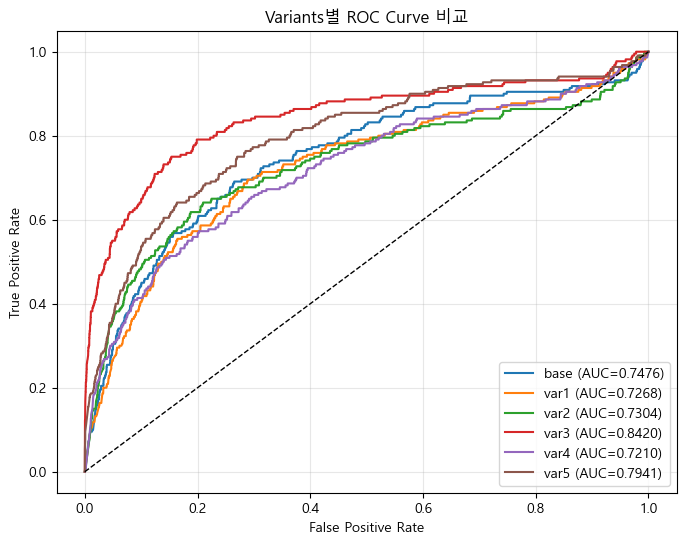

In [ ]:
#%% 

# [ROC Curve 통합 시각화]
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
plt.figure(figsize=(8, 6))
for name, res in roc_data.items():
    plt.plot(res['fpr'], res['tpr'], label=f"{name} (AUC={res['auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Variants별 ROC Curve 비교")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

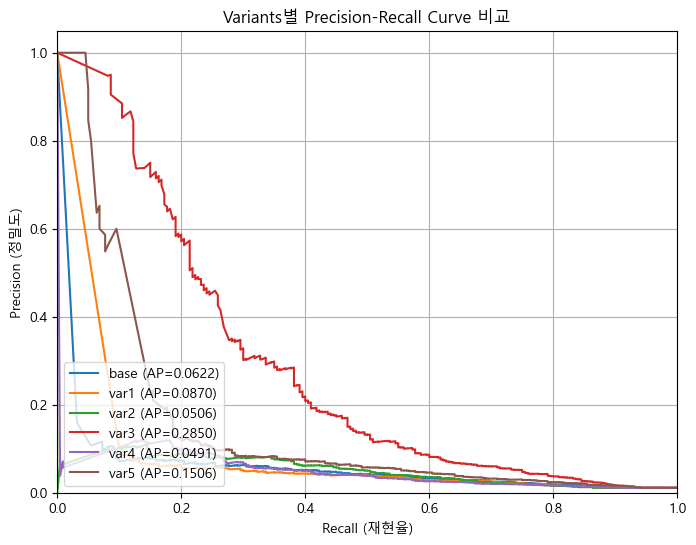

In [ ]:
#%%

# PR Curve 통합 시각화
plt.figure(figsize=(8, 6))
for name, res in pr_data.items():
    plt.plot(res['recall'], res['precision'], label=f"{name} (AP={res['auc']:.4f})") # AP = Average Precision, PR AUC와 동일

plt.xlabel("Recall (재현율)")
plt.ylabel("Precision (정밀도)")
plt.title("Variants별 Precision-Recall Curve 비교")
plt.legend(loc="lower left")
plt.grid(True)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()